In [48]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

import featuretools as ft
print(ft.__version__)

import re
import datetime as dt

import warnings 
warnings.filterwarnings('ignore')

0.16.0


In [3]:
# Read in the datasets and limit to the first 1000 rows (sorted by SK_ID_CURR) 
# This allows us to actually see the results in a reasonable amount of time! 
app_train = pd.read_csv('C:/Users/Amgad/Downloads/voda/data/application_train.csv').sort_values('SK_ID_CURR').reset_index().loc[:1000, :].drop(columns = ['index'])
app_test = pd.read_csv('C:/Users/Amgad/Downloads/voda/data/application_test.csv').sort_values('SK_ID_CURR').reset_index().loc[:1000, :].drop(columns = ['index'])
bureau = pd.read_csv('C:/Users/Amgad/Downloads/voda/data/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index().loc[:1000, :].drop(columns = ['index'])
bureau_balance = pd.read_csv('C:/Users/Amgad/Downloads/voda/data/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index().loc[:1000, :].drop(columns = ['index'])
cash = pd.read_csv('C:/Users/Amgad/Downloads/voda/data/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
credit = pd.read_csv('C:/Users/Amgad/Downloads/voda/data/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
previous = pd.read_csv('C:/Users/Amgad/Downloads/voda/data/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
installments = pd.read_csv('C:/Users/Amgad/Downloads/voda/data/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])

In [4]:
app_types = {}

# Iterate through the columns and record the Boolean columns
for col in app_train:
    # If column is a number with only two values, encode it as a Boolean
    if (app_train[col].dtype != 'object') and (len(app_train[col].unique()) <= 2):
        app_types[col] = ft.variable_types.Boolean

print('Number of boolean variables: ', len(app_types))

Number of boolean variables:  33


In [5]:
# Record ordinal variables
app_types['REGION_RATING_CLIENT'] = ft.variable_types.Ordinal
app_types['REGION_RATING_CLIENT_W_CITY'] = ft.variable_types.Ordinal

app_test_types = app_types.copy()
del app_test_types['TARGET']

In [6]:
# Record boolean variables in the previous data
previous_types= {'NFLAG_LAST_APPL_IN_DAY': ft.variable_types.Boolean,
                 'NFLAG_INSURED_ON_APPROVAL': ft.variable_types.Boolean}

In [7]:
# Replace Outliers
import re

def replace_day_outliers(df):
    """Replace 365243 with np.nan in any columns with DAYS"""
    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})

    return df

# Replace all the day outliers
app_train = replace_day_outliers(app_train)
app_test = replace_day_outliers(app_test)
bureau = replace_day_outliers(bureau)
bureau_balance = replace_day_outliers(bureau_balance)
credit = replace_day_outliers(credit)
cash = replace_day_outliers(cash)
previous = replace_day_outliers(previous)
installments = replace_day_outliers(installments)

In [8]:
# Establish a starting date for all applications at Home Credit
start_date = pd.Timestamp("2016-01-01")
start_date

Timestamp('2016-01-01 00:00:00')

In [9]:
# Convert to timedelta in days
for col in ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']:
    bureau[col] = pd.to_timedelta(bureau[col], 'D')
    
bureau[['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']].head()

DAYS_CREDIT DAYS_CREDIT_ENDDATE DAYS_ENDDATE_FACT DAYS_CREDIT_UPDATE
0   -857 days           -492 days         -553 days          -155 days
1   -909 days           -179 days         -877 days          -155 days
2   -879 days           -514 days         -544 days          -155 days
3  -1572 days          -1329 days        -1328 days          -155 days
4   -559 days            902 days               NaT            -6 days

In [10]:
# Create the date columns
bureau['bureau_credit_application_date'] = start_date + bureau['DAYS_CREDIT']
bureau['bureau_credit_end_date'] = start_date + bureau['DAYS_CREDIT_ENDDATE']
bureau['bureau_credit_close_date'] = start_date + bureau['DAYS_ENDDATE_FACT']
bureau['bureau_credit_update_date'] = start_date + bureau['DAYS_CREDIT_UPDATE']

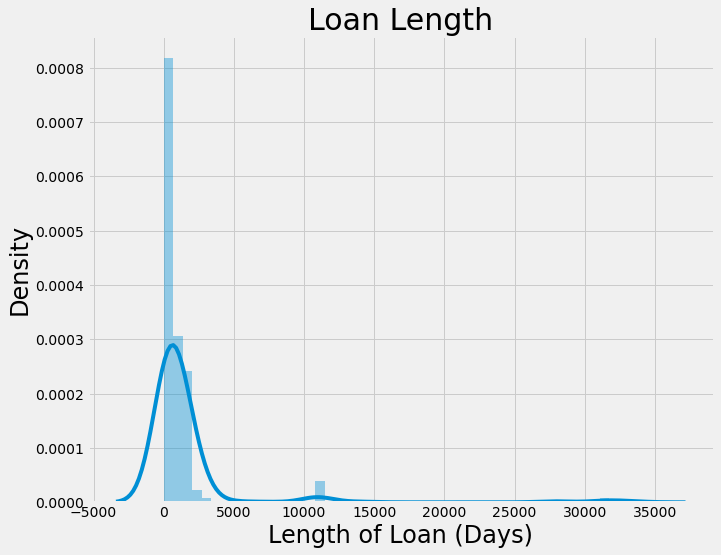

In [11]:
# Set up default plot styles
plt.rcParams['font.size'] = 26
plt.style.use('fivethirtyeight')

# Drop the time offset columns
bureau = bureau.drop(columns = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE'])

plt.figure(figsize = (10, 8))
sns.distplot((bureau['bureau_credit_end_date'] - bureau['bureau_credit_application_date']).dropna().dt.days);
plt.xlabel('Length of Loan (Days)', size = 24); plt.ylabel('Density', size = 24); plt.title('Loan Length', size = 30);

In [12]:
# # Convert to timedelta
# bureau_balance['MONTHS_BALANCE'] = pd.to_timedelta(bureau_balance['MONTHS_BALANCE'], 'M')

# # Make a date column
# bureau_balance['bureau_balance_date'] = start_date + bureau_balance['MONTHS_BALANCE']
# bureau_balance = bureau_balance.drop(columns = ['MONTHS_BALANCE'])

# # Select one loan and plot
# example_credit = bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5001709]
# plt.plot(example_credit['bureau_balance_date'], example_credit['STATUS'], 'ro');
# plt.title('Loan 5001709 over Time'); plt.xlabel('Date'); plt.ylabel('Status');

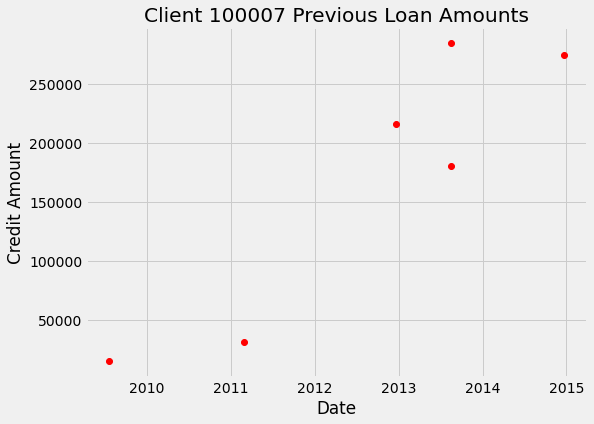

In [13]:
# Convert to timedeltas in days
for col in ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    previous[col] = pd.to_timedelta(previous[col], 'D')
    
# Make date columns
previous['previous_decision_date'] = start_date + previous['DAYS_DECISION']
previous['previous_drawing_date'] = start_date + previous['DAYS_FIRST_DRAWING']
previous['previous_first_due_date'] = start_date + previous['DAYS_FIRST_DUE']
previous['previous_last_duefirst_date'] = start_date + previous['DAYS_LAST_DUE_1ST_VERSION']
previous['previous_last_due_date'] = start_date + previous['DAYS_LAST_DUE']
previous['previous_termination_date'] = start_date + previous['DAYS_TERMINATION']

# Drop the time offset columns
previous = previous.drop(columns = ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION'])

plt.figure(figsize = (8, 6))
example_client = previous[previous['SK_ID_CURR'] == 100007]
plt.plot(example_client['previous_decision_date'], example_client['AMT_CREDIT'], 'ro')
plt.title('Client 100007 Previous Loan Amounts'); plt.xlabel('Date'); plt.ylabel('Credit Amount');


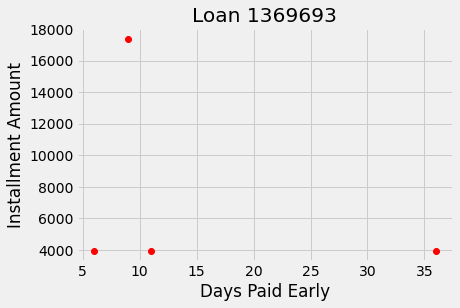

In [14]:
# Conver to time delta object
installments['DAYS_INSTALMENT'] = pd.to_timedelta(installments['DAYS_INSTALMENT'], 'D')
installments['DAYS_ENTRY_PAYMENT'] = pd.to_timedelta(installments['DAYS_ENTRY_PAYMENT'], 'D')

# Create time column and drop
installments['installments_due_date'] = start_date + installments['DAYS_INSTALMENT']
installments = installments.drop(columns = ['DAYS_INSTALMENT'])

installments['installments_paid_date'] = start_date + installments['DAYS_ENTRY_PAYMENT']
installments = installments.drop(columns = ['DAYS_ENTRY_PAYMENT'])

# Select one loan and plot
example_credit = installments[installments['SK_ID_PREV'] == 1369693]
plt.plot((example_credit['installments_due_date'] - example_credit['installments_paid_date']).dt.days, example_credit['AMT_INSTALMENT'], 'ro');
plt.title('Loan 1369693'); plt.xlabel('Days Paid Early'); plt.ylabel('Installment Amount');


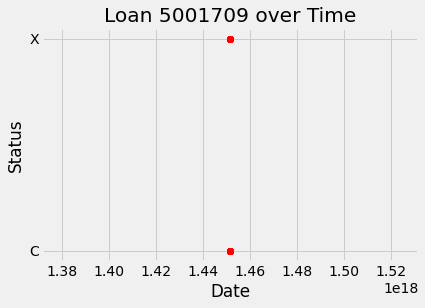

In [15]:
bureau_balance['start_date'] = bureau_balance['MONTHS_BALANCE'].apply(lambda x: len(bureau_balance['MONTHS_BALANCE']))
bureau_balance['start_date'] = pd.to_datetime('2016-01-01')
# Make a date column

x = bureau_balance['start_date'].values.astype("float64")
y = bureau_balance['MONTHS_BALANCE'].values.astype("float64")

bureau_balance['bureau_balance_date'] = x + y

# pd.to_timedelta(df['A']) + pd.to_datetime(df['B'])
bureau_balance = bureau_balance.drop(columns = ['MONTHS_BALANCE'])

# Select one loan and plot
example_credit = bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5001709]
plt.plot(example_credit['bureau_balance_date'], example_credit['STATUS'], 'ro');
plt.title('Loan 5001709 over Time'); plt.xlabel('Date'); plt.ylabel('Status');

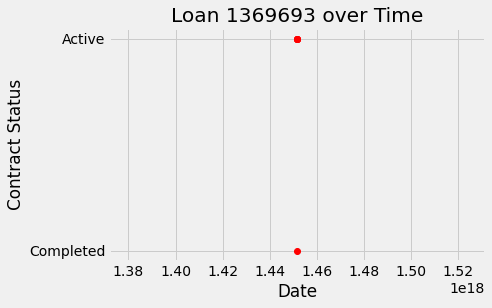

In [16]:
credit['start_date'] = credit['MONTHS_BALANCE'].apply(lambda x: len(credit['MONTHS_BALANCE']))
credit['start_date'] = pd.to_datetime('2016-01-01')
# Make a date column

x = credit['start_date'].values.astype("float64")
y = credit['MONTHS_BALANCE'].values.astype("float64")

credit['credit_balance_date'] = x + y
credit = credit.drop(columns = ['MONTHS_BALANCE'])

cash['start_date'] = cash['MONTHS_BALANCE'].apply(lambda x: len(cash['MONTHS_BALANCE']))
cash['start_date'] = pd.to_datetime('2016-01-01')
# Make a date column

x = cash['start_date'].values.astype("float64")
y = cash['MONTHS_BALANCE'].values.astype("float64")

cash['cash_balance_date'] = x + y
#########

# Make a date column
cash = cash.drop(columns = ['MONTHS_BALANCE'])

# Select on loan and plot
example_credit = cash[cash['SK_ID_PREV'] == 1369693]

plt.plot(example_credit['cash_balance_date'], example_credit['NAME_CONTRACT_STATUS'], 'ro');
plt.title('Loan 1369693 over Time'); plt.xlabel('Date'); plt.ylabel('Contract Status');

In [17]:
del credit['start_date']
del cash['start_date']
del bureau_balance['start_date']

In [18]:
bureau_balance.bureau_balance_date = pd.to_datetime(bureau_balance.bureau_balance_date)
cash.cash_balance_date = pd.to_datetime(cash.cash_balance_date)
credit.credit_balance_date = pd.to_datetime(credit.credit_balance_date)

In [19]:
# Make an entityset
es = ft.EntitySet(id = 'clients')

In [20]:
# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'app_train', dataframe = app_train, 
                              index = 'SK_ID_CURR', variable_types = app_types)

es = es.entity_from_dataframe(entity_id = 'app_test', dataframe = app_test, 
                              index = 'SK_ID_CURR', variable_types = app_test_types)

es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, 
                              index = 'SK_ID_BUREAU', time_index='bureau_credit_application_date')

es = es.entity_from_dataframe(entity_id = 'previous', dataframe = previous, 
                              index = 'SK_ID_PREV', time_index = 'previous_decision_date',
                              variable_types = previous_types)

# Entities that do not have a unique index
es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bb_index',
                              time_index = 'bureau_balance_date')

es = es.entity_from_dataframe(entity_id = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index',
                              time_index = 'cash_balance_date')

es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index',
                              time_index = 'installments_paid_date')

es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index',
                              time_index = 'credit_balance_date')

In [21]:
# Relationship between app and bureau
r_app_bureau = ft.Relationship(es['app_train']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Test Relationship between app and bureau
r_test_app_bureau = ft.Relationship(es['app_test']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es['app_train']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Test Relationship between current app and previous apps
r_test_app_previous = ft.Relationship(es['app_test']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['cash']['SK_ID_PREV'])
r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])
r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])

# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_test_app_bureau, r_bureau_balance, r_app_previous, r_test_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: clients
  Entities:
    app_train [Rows: 1001, Columns: 122]
    app_test [Rows: 1001, Columns: 121]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 37]
    bureau_balance [Rows: 1001, Columns: 4]
    cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app_train.SK_ID_CURR
    bureau.SK_ID_CURR -> app_test.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app_train.SK_ID_CURR
    previous.SK_ID_CURR -> app_test.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

In [22]:
time_features, time_feature_names = ft.dfs(entityset = es, target_entity = 'app_train', 
                                           trans_primitives = ['cum_sum', 'time_since_previous'], max_depth = 2,
                                           agg_primitives = ['trend'] ,
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train),
                                           ignore_entities = ['app_test'])

Built 452 features
Elapsed: 00:19 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [23]:
time_features.iloc[:, -10:].head()

CUM_SUM(TREND(installments.NUM_INSTALMENT_VERSION, installments_paid_date))  \
SK_ID_CURR                                                                                
100002                                               0.000500                             
100003                                               0.000561                             
100004                                               0.015538                             
100006                                               0.015421                             
100007                                               0.015611                             

            CUM_SUM(TREND(previous.RATE_INTEREST_PRIVILEGED, previous_decision_date))  \
SK_ID_CURR                                                                              
100002                                                    NaN                           
100003                                                    NaN                           
100004                                                    NaN                           
100006                                                    NaN                           
100007                                                    NaN                           

            CUM_SUM(TREND(bureau.AMT_CREDIT_SUM_LIMIT, bureau_credit_application_date))  \
SK_ID_CURR                                                                                
100002                                              23.113250                             
100003                                             282.338613                             
100004                                                    NaN                             
100006                                                    NaN                             
100007                                                    NaN                             

            CUM_SUM(TREND(bureau.CNT_CREDIT_PROLONG, bureau_credit_application_date))  \
SK_ID_CURR                                                                              
100002                                                    0.0                           
100003                                                    0.0                           
100004                                                    NaN                           
100006                                                    NaN                           
100007                                                    NaN                           

            CUM_SUM(TREND(installments.NUM_INSTALMENT_NUMBER, installments_paid_date))  \
SK_ID_CURR                                                                               
100002                                               0.032698                            
100003                                               0.031303                            
100004                                               0.060681                            
100006                                               0.070297                            
100007                                               0.072092                            

            CUM_SUM(TREND(cash.CNT_INSTALMENT_FUTURE, cash_balance_date))  \
SK_ID_CURR                                                                  
100002                                                    0.0               
100003                                                    0.0               
100004                                                    0.0               
100006                                                    0.0               
100007                                                    0.0               

            CUM_SUM(TREND(bureau.AMT_CREDIT_SUM_OVERDUE, bureau_credit_application_date))  \
SK_ID_CURR                                                                                  
100002                                                    0.0                               
100003                                

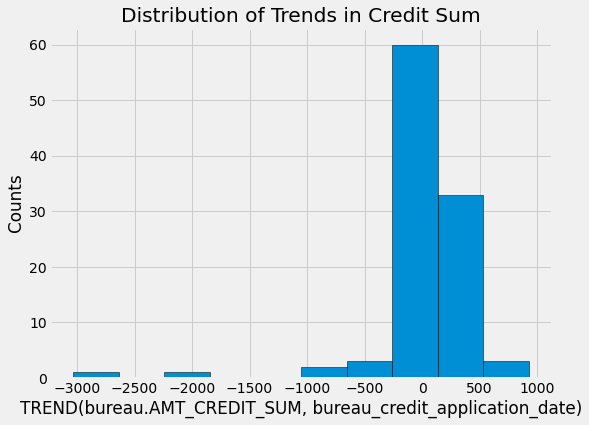

In [24]:
plt.figure(figsize = (8, 6))
plt.hist(time_features['TREND(bureau.AMT_CREDIT_SUM, bureau_credit_application_date)'].dropna(), edgecolor = 'k');
plt.xlabel('TREND(bureau.AMT_CREDIT_SUM, bureau_credit_application_date)'); plt.ylabel('Counts'); plt.title('Distribution of Trends in Credit Sum');

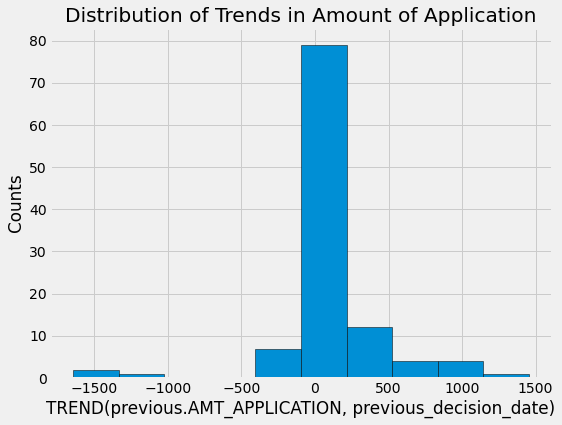

In [25]:
plt.figure(figsize = (8, 6))
plt.hist(time_features['TREND(previous.AMT_APPLICATION, previous_decision_date)'].dropna(), edgecolor = 'k');
plt.xlabel('TREND(previous.AMT_APPLICATION, previous_decision_date)'); plt.ylabel('Counts'); plt.title('Distribution of Trends in Amount of Application');

In [26]:
time_feature_names[-10:]

[<Feature: CUM_SUM(TREND(installments.NUM_INSTALMENT_VERSION, installments_paid_date))>,
 <Feature: CUM_SUM(TREND(previous.RATE_INTEREST_PRIVILEGED, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(bureau.AMT_CREDIT_SUM_LIMIT, bureau_credit_application_date))>,
 <Feature: CUM_SUM(TREND(bureau.CNT_CREDIT_PROLONG, bureau_credit_application_date))>,
 <Feature: CUM_SUM(TREND(installments.NUM_INSTALMENT_NUMBER, installments_paid_date))>,
 <Feature: CUM_SUM(TREND(cash.CNT_INSTALMENT_FUTURE, cash_balance_date))>,
 <Feature: CUM_SUM(TREND(bureau.AMT_CREDIT_SUM_OVERDUE, bureau_credit_application_date))>,
 <Feature: CUM_SUM(TREND(previous.CNT_PAYMENT, previous_decision_date))>,
 <Feature: CUM_SUM(TREND(bureau.AMT_CREDIT_MAX_OVERDUE, bureau_credit_application_date))>,
 <Feature: CUM_SUM(TREND(credit.AMT_BALANCE, credit_balance_date))>]

In [27]:
previous['NAME_CONTRACT_STATUS'].value_counts()

Approved        594
Refused         206
Canceled        186
Unused offer     15
Name: NAME_CONTRACT_STATUS, dtype: int64

In [28]:
# Assign interesting values
es['previous']['NAME_CONTRACT_STATUS'].interesting_values = ['Approved', 'Refused', 'Canceled']

# Calculate the features with intereseting values
interesting_features, interesting_feature_names = ft.dfs(entityset=es, target_entity='app_train', max_depth = 1, 
                                                         where_primitives = ['mean', 'mode'], 
                                                         trans_primitives=[], features_only = False, verbose = True,
                                                         chunk_size = len(app_train),
                                                         ignore_entities = ['app_test'])

Built 355 features
Elapsed: 00:02 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [29]:
interesting_features.iloc[:, -6:, ].head()

MODE(previous.NAME_PRODUCT_TYPE WHERE NAME_CONTRACT_STATUS = Canceled)  \
SK_ID_CURR                                                                          
100002                                                    NaN                       
100003                                                    NaN                       
100004                                                    NaN                       
100006                                                    XNA                       
100007                                                    NaN                       

           MODE(previous.NAME_PRODUCT_TYPE WHERE NAME_CONTRACT_STATUS = Approved)  \
SK_ID_CURR                                                                          
100002                                                    XNA                       
100003                                                    XNA                       
100004                                                    XNA                       
100006                                                 x-sell                       
100007                                                 x-sell                       

           MODE(previous.NAME_PRODUCT_TYPE WHERE NAME_CONTRACT_STATUS = Refused)  \
SK_ID_CURR                                                                         
100002                                                    NaN                      
100003                                                    NaN                      
100004                                                    NaN                      
100006                                                 x-sell                      
100007                                                    NaN                      

           MODE(previous.NAME_PAYMENT_TYPE WHERE NAME_CONTRACT_STATUS = Canceled)  \
SK_ID_CURR                                                                          
100002                                                    NaN                       
100003                                                    NaN                       
100004                                                    NaN                       
100006                                                    XNA                       
100007                                                    NaN                       

           MODE(previous.NAME_PAYMENT_TYPE WHERE NAME_CONTRACT_STATUS = Approved)  \
SK_ID_CURR                                                                          
100002                                                    XNA                       
100003                                  Cash through the bank                       
100004                                  Cash through the bank                       
100006                                  Cash through the bank                       
100007                                  Cash through the bank                       

           MODE(previous.NAME_PAYMENT_TYPE WHERE NAME_CONTRACT_STATUS = Refused)  
SK_ID_CURR                                                                        
100002                                                    NaN                     
100003                                                    NaN                     
100004                                                    NaN                     
100006                                  Cash through the bank                     
100007                                                    NaN

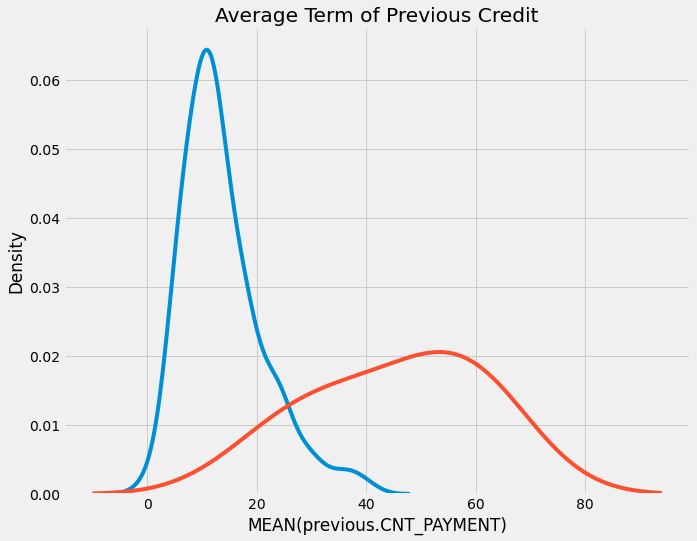

In [30]:
plt.figure(figsize = (10, 8))
sns.kdeplot(interesting_features['MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Approved)'].dropna(), label = 'Approved')
sns.kdeplot(interesting_features['MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Canceled)'].dropna(), label = 'Canceled')
plt.xlabel('MEAN(previous.CNT_PAYMENT)'); plt.ylabel('Density'); plt.title('Average Term of Previous Credit');

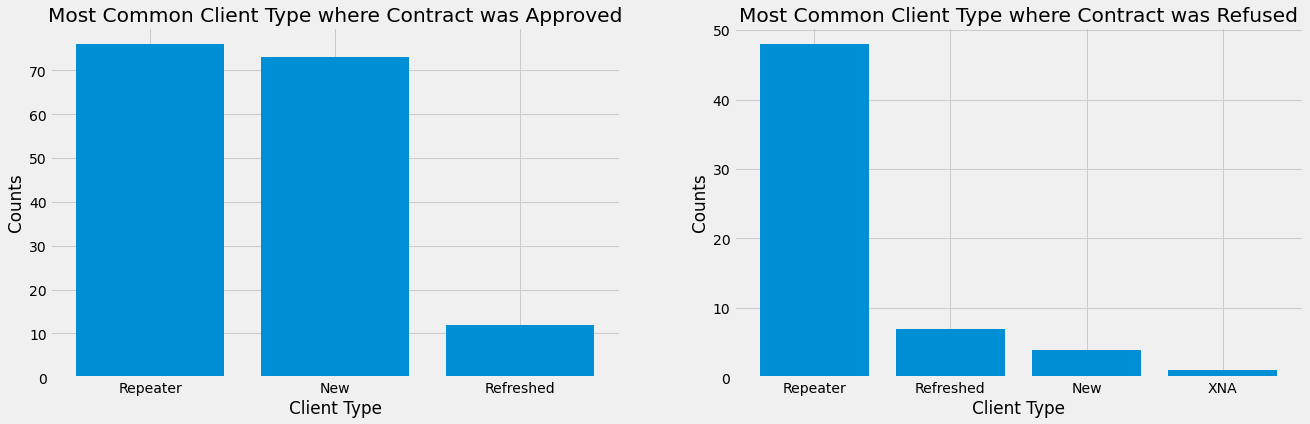

In [31]:
# Plot of client type when contract was approved
plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.bar(list(range(3)), interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Approved)'].value_counts())
plt.xticks(list(range(3)), interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Approved)'].value_counts().index);
plt.xlabel("Client Type"); plt.ylabel("Counts");
plt.title("Most Common Client Type where Contract was Approved");

# Plot of client type where contract was refused
plt.subplot(1, 2, 2)
plt.bar(list(range(4)), interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Refused)'].value_counts())
plt.xticks(list(range(4)), interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Refused)'].value_counts().index);
plt.xlabel("Client Type"); plt.ylabel("Counts");
plt.title("Most Common Client Type where Contract was Refused");

In [34]:
# Late Payment seed feature
late_payment = ft.Feature(es['installments']['installments_due_date']) < ft.Feature(es['installments']['installments_paid_date'])

# Rename the feature
late_payment = late_payment.rename("late_payment")

# DFS with seed features
seed_features, seed_feature_names = ft.dfs(entityset = es,
                                           target_entity = 'app_train',
                                           agg_primitives = ['percent_true', 'mean'],
                                           trans_primitives = [], 
                                           seed_features = [late_payment],
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train),
                                           ignore_entities = ['app_test'])

Built 251 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [35]:
seed_features.iloc[:, -2:].head(10)

MEAN(credit.previous.RATE_DOWN_PAYMENT)  \
SK_ID_CURR                                            
100002                                          NaN   
100003                                          NaN   
100004                                          NaN   
100006                                          NaN   
100007                                          NaN   
100008                                          NaN   
100009                                          NaN   
100010                                          NaN   
100011                                          NaN   
100012                                          NaN   

            MEAN(previous.PERCENT_TRUE(installments.late_payment))  
SK_ID_CURR                                                          
100002                                               0.000000       
100003                                               0.000000       
100004                                               0.000000       
100006                                               0.000000       
100007                                               0.239927       
100008                                               0.018182       
100009                                               0.000000       
100010                                               0.000000       
100011                                               0.207870       
100012                                               0.089015

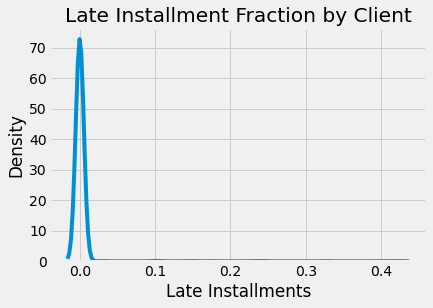

In [36]:
sns.kdeplot(seed_features['PERCENT_TRUE(installments.late_payment)'].dropna(), label = '')
plt.xlabel('Late Installments'); plt.ylabel('Density'); plt.title('Late Installment Fraction by Client');

In [37]:
# Create a feed representing whether the loan is past due
past_due = ft.Feature(es['bureau_balance']['STATUS']).isin(['1', '2', '3', '4', '5'])
past_due = past_due.rename("past_due")

In [38]:
# DFS with specified seed feature
seed_features, seed_feature_names = ft.dfs(entityset = es,
                                           target_entity = 'app_train',
                                           agg_primitives = ['percent_true', 'mean'],
                                           trans_primitives = [], 
                                           seed_features = [past_due],
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train),
                                           ignore_entities = ['app_test'])

Built 251 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [39]:

from featuretools.variable_types import (
    Boolean, Datetime,
    DatetimeTimeIndex,
    Discrete,
    Index,
    Numeric,
    Variable,
    Id
)

from featuretools.primitives import AggregationPrimitive, make_agg_primitive
from datetime import datetime, timedelta

from collections import Counter


def normalized_mode_count(x):
    """
    Return the fraction of total observations that 
    are the most common observation. For example, 
    in an array of ['A', 'A', 'A', 'B', 'B'], the 
    function will return 0.6."""
    
    if x.mode().shape[0] == 0:
        return np.nan
            
    # Count occurence of each value
    counts = dict(Counter(x.values))
    # Find the mode
    mode = x.mode().iloc[0]
    # Divide the occurences of mode by the total occurrences
    return counts[mode] / np.sum(list(counts.values()))
    

NormalizedModeCount = make_agg_primitive(function = normalized_mode_count, 
                                         input_types = [Discrete],
                                         return_type = Numeric)

def longest_repetition(x):
    """
    Returns the item with most consecutive occurrences in `x`. 
    If there are multiple items with the same number of conseqcutive occurrences,
    it will return the first one. If `x` is empty, returns None. 
    """
    
    x = x.dropna()
    
    if x.shape[0] < 1:
        return None
    
    # Set the longest element
    longest_element = current_element = None
    longest_repeats = current_repeats = 0
    
    # Iterate through the iterable
    for element in x:
        if current_element == element:
            current_repeats += 1
        else:
            current_element = element
            current_repeats = 1
        if current_repeats > longest_repeats:
            longest_repeats = current_repeats
            longest_element = current_element
            
    return longest_element

LongestSeq = make_agg_primitive(function = longest_repetition,
                                     input_types = [Discrete],
                                     return_type = Discrete) 

In [40]:
# DFS with custom features
custom_features, custom_feature_names = ft.dfs(entityset = es,
                                              target_entity = 'app_train',
                                              agg_primitives = [NormalizedModeCount, LongestSeq],
                                              max_depth = 2,
                                              trans_primitives = [],
                                              features_only = False, verbose = True,
                                              chunk_size = len(app_train),
                                              ignore_entities = ['app_test'])

custom_features.iloc[:, -40:].head()

Built 281 features
Elapsed: 00:03 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


LONGEST_REPETITION(installments.previous.NAME_GOODS_CATEGORY)  \
SK_ID_CURR                                                                 
100002                                               Vehicles              
100003                                   Consumer Electronics              
100004                                                 Mobile              
100006                                            Audio/Video              
100007                                                    XNA              

           LONGEST_REPETITION(installments.previous.NAME_CLIENT_TYPE)  \
SK_ID_CURR                                                              
100002                                                    New           
100003                                              Refreshed           
100004                                                    New           
100006                                               Repeater           
100007                                               Repeater           

           LONGEST_REPETITION(installments.previous.NAME_CASH_LOAN_PURPOSE)  \
SK_ID_CURR                                                                    
100002                                                    XAP                 
100003                                                    XAP                 
100004                                                    XAP                 
100006                                                    XAP                 
100007                                                    XNA                 

           LONGEST_REPETITION(installments.previous.PRODUCT_COMBINATION)  \
SK_ID_CURR                                                                 
100002                                POS other with interest              
100003                            POS household with interest              
100004                            POS mobile without interest              
100006                            POS household with interest              
100007                               POS mobile with interest              

           LONGEST_REPETITION(installments.previous.NAME_YIELD_GROUP)  \
SK_ID_CURR                                                              
100002                                             low_normal           
100003                                                 middle           
100004                                                 middle           
100006                                                   high           
100007                                                   high           

           LONGEST_REPETITION(installments.previous.NAME_PRODUCT_TYPE)  \
SK_ID_CURR                                                               
100002                                                    XNA            
100003                                                    XNA            
100004                                                    XNA            
100006                                                    XNA            
100007                                                    XNA            

            NORMALIZED_MODE_COUNT(credit.previous.NAME_PRODUCT_TYPE)  \
SK_ID_CURR                                                             
100002                                                    NaN          
100003                                                    NaN          
100004                                                    NaN          
100006                                                    1.0          
100007                                                    NaN          

            NORMALIZED_MODE_COUNT(credit.previous.NAME_PORTFOLIO)  \
SK_ID_CURR                                                          
100002                                                    NaN       
100003                                                    NaN       
100004                                                    NaN      

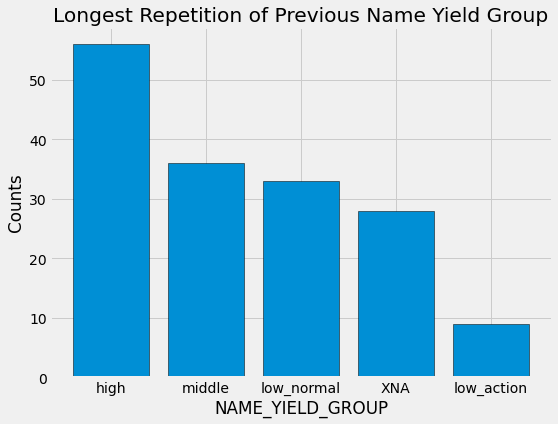

In [41]:
plt.figure(figsize = (8, 6))
plt.bar(custom_features['LONGEST_REPETITION(previous.NAME_YIELD_GROUP)'].value_counts().index, custom_features['LONGEST_REPETITION(previous.NAME_YIELD_GROUP)'].value_counts(), edgecolor = 'k')
plt.xlabel('NAME_YIELD_GROUP'); plt.ylabel('Counts'); plt.title('Longest Repetition of Previous Name Yield Group');

<AxesSubplot:xlabel='NORMALIZED_MODE_COUNT(previous.NAME_PRODUCT_TYPE)', ylabel='Density'>

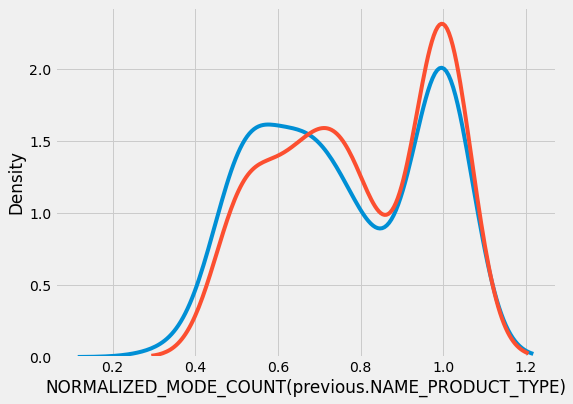

In [42]:
plt.figure(figsize = (8, 6))
sns.kdeplot(custom_features['NORMALIZED_MODE_COUNT(previous.NAME_PRODUCT_TYPE)'], label = 'NORMALIZED_MODE_COUNT(previous.NAME_PRODUCT_TYPE)')
sns.kdeplot(custom_features['NORMALIZED_MODE_COUNT(bureau.CREDIT_ACTIVE)'], label = 'NORMALIZED_MODE_COUNT(bureau.CREDIT_ACTIVE)')

In [43]:
def most_recent(y, x):
    df = pd.DataFrame({"x": x, "y": y}).dropna()
            
    if df.shape[0] < 1:
        return np.nan

    # Sort the values by timestamps reversed
    df = df.sort_values('x', ascending = False).reset_index()

    # Return the most recent occurence
    return df.iloc[0]['y']

MostRecent = make_agg_primitive(function = most_recent,
                                input_types = [Discrete, Datetime],
                                return_type = Discrete)

In [44]:
# DFS with custom feature
custom_features, custom_feature_names = ft.dfs(entityset = es,
                                              target_entity = 'app_train',
                                              agg_primitives = ['last', MostRecent],
                                               max_depth = 1,
                                              trans_primitives = [],
                                              features_only = False, verbose = True,
                                              chunk_size = len(app_train),
                                              ignore_entities = ['app_test'])

Built 271 features
Elapsed: 00:29 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [45]:
custom_features[['MOST_RECENT(bureau.CREDIT_TYPE, bureau_credit_end_date)', 'MOST_RECENT(bureau.CREDIT_TYPE, bureau_credit_application_date)']].head(10)

MOST_RECENT(bureau.CREDIT_TYPE, bureau_credit_end_date)  \
SK_ID_CURR                                                           
100002                                        Consumer credit        
100003                                            Credit card        
100004                                        Consumer credit        
100006                                                    NaN        
100007                                        Consumer credit        
100008                                        Consumer credit        
100009                                        Consumer credit        
100010                                        Consumer credit        
100011                                            Credit card        
100012                                                    NaN        

           MOST_RECENT(bureau.CREDIT_TYPE, bureau_credit_application_date)  
SK_ID_CURR                                                                  
100002                                            Credit card               
100003                                            Credit card               
100004                                        Consumer credit               
100006                                                    NaN               
100007                                        Consumer credit               
100008                                        Consumer credit               
100009                                            Credit card               
100010                                        Consumer credit               
100011                                        Consumer credit               
100012                                                    NaN

In [46]:
# Run and create the features
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'app_train',
                                       agg_primitives = ['mean', 'max', 'min', 'trend', 'mode', 'count', 
                                                         'sum', 'percent_true', NormalizedModeCount, MostRecent, LongestSeq],
                                       trans_primitives = ['diff', 'cum_sum', 'cum_mean', 'percentile'], 
                                       where_primitives = ['mean', 'sum'],
                                       seed_features = [late_payment, past_due],
                                       max_depth = 2, features_only = False, verbose = True,
                                       chunk_size = len(app_train),
                                       ignore_entities = ['app_test'])

Built 5919 features
Elapsed: 02:54 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [47]:
# Run and create the features
feature_matrix_test, feature_names_test = ft.dfs(entityset = es, target_entity = 'app_test',
                                                   agg_primitives = ['mean', 'max', 'min', 'trend', 'mode', 'count', 
                                                                     'sum', 'percent_true', NormalizedModeCount, MostRecent, LongestSeq],
                                                   trans_primitives = ['diff', 'cum_sum', 'cum_mean', 'percentile'], 
                                                   where_primitives = ['mean', 'sum'],
                                                   seed_features = [late_payment, past_due],
                                                   max_depth = 2, features_only = False, verbose = True,
                                                   chunk_size = len(app_test),
                                                   ignore_entities = ['app_train'])

Built 5918 features
Elapsed: 01:31 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [49]:
random.sample(feature_names, 10)

[<Feature: CUM_MEAN(MAX(credit.CNT_DRAWINGS_CURRENT))>,
 <Feature: MEAN(previous.CUM_SUM(SELLERPLACE_AREA) WHERE NAME_CONTRACT_STATUS = Canceled)>,
 <Feature: MOST_RECENT(previous.LONGEST_REPETITION(cash.NAME_CONTRACT_STATUS), previous_last_duefirst_date)>,
 <Feature: CUM_SUM(MIN(bureau.AMT_CREDIT_SUM_LIMIT))>,
 <Feature: CUM_SUM(MAX(installments.AMT_PAYMENT))>,
 <Feature: MOST_RECENT(installments.previous.CHANNEL_TYPE, previous.previous_termination_date)>,
 <Feature: MAX(previous.MIN(cash.SK_DPD_DEF))>,
 <Feature: MEAN(credit.AMT_RECEIVABLE_PRINCIPAL)>,
 <Feature: MIN(previous.TREND(credit.AMT_TOTAL_RECEIVABLE, credit_balance_date))>,
 <Feature: PERCENTILE(CUM_MEAN(DAYS_ID_PUBLISH))>]

In [50]:
from featuretools import selection

# Remove low information features
feature_matrix2 = selection.remove_low_information_features(feature_matrix)
print('Removed %d features from training features'  % (feature_matrix.shape[1] - feature_matrix2.shape[1]))

feature_matrix_test2 = selection.remove_low_information_features(feature_matrix_test)
print('Removed %d features from testing features' % (feature_matrix_test.shape[1] - feature_matrix_test2.shape[1]))

Removed 1231 features from training features
Removed 1286 features from testing features


In [51]:
train_labels = feature_matrix['TARGET']
feature_matrix, feature_matrix_test = feature_matrix2.align(feature_matrix_test2, join = 'inner', axis = 1)
feature_matrix['TARGET'] = train_labels

print('Final training shape: ', feature_matrix.shape)
print('Final testing shape: ', feature_matrix_test.shape)

Final training shape:  (1001, 4633)
Final testing shape:  (1001, 4632)


In [52]:
# Save the feature matrix to a csv
feature_matrix.to_csv('feature_matrix.csv')
feature_matrix_test.to_csv('feature_matrix_test.csv')